# Study for Different Models and their peformance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
from tqdm import trange
from time import sleep
from sklearn.model_selection import learning_curve, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# %%time
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/release/bin'
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# 1. For the Sheet name 100, ie. with 100 entries

In [2]:
df_UPCAT = pd.read_excel('UPCAT_DATA2.xlsx', sheetname='100') #Sheet1-Multiclass
dummy = df_UPCAT
dummy.head()

,Eng7,Eng8,Eng9,Math7,Math8,Math9,Sci7,Sci8,Sci9,GWA7,GWA8,GWA9,IQ,SA,Target
0,77,82,86,94,87,92,84,80,92,1.4764,1.5045,1.4098,55,28,1
1,57,57,59,55,46,57,53,45,53,2.6557,2.7000,2.7008,38,19,0
2,55,52,55,57,53,51,57,62,51,2.6132,2.6818,2.7172,17,9,0
3,69,78,78,87,79,79,83,82,79,1.7217,1.6136,1.7049,45,28,0
4,64,71,68,71,57,54,60,59,55,2.4245,2.4318,2.4713,67,56,0


In [3]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



X_transition = pd.DataFrame(df_UPCAT)
X_clean = DataFrameImputer().fit_transform(X_transition)

X_clean.isnull().sum()

Eng7      0
Eng8      0
Eng9      0
Math7     0
Math8     0
Math9     0
Sci7      0
Sci8      0
Sci9      0
GWA7      0
GWA8      0
GWA9      0
IQ        0
SA        0
Target    0
dtype: int64

In [8]:
Number_trials=10

def train_knn(X, y, scale=None):
    """
    Implements KNN Classification
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    scale - Default is None. Specify scaler e.g StandardScaler or MinMaxScaler
    
    """
    score_train = []
    score_test = []
    
    
    print('KNN Classifier')
    for seed in tqdm(range(Number_trials)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        if scale:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

        neighbors_settings = range(1,70)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:   
            clf = KNeighborsClassifier(n_neighbors=n_neighbors) # build the model 
            clf.fit(X_train, y_train)    
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)   
        
    score = np.mean(score_test, axis=0)
    #auc = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]) only for binary classification
    #return n_neighbor, accuracy
#     print('Scaling used is: ', scale)
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'NA']

def train_logistic(X, y, reg, scale=None):
    """
    Implements Logistic Regression
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    reg - Regularization Parameter (l1/l2)
    scale - Default is None. Specify scaler e.g StandardScaler or MinMaxScaler
    
    """
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

    score_train = []
    score_test = []
    weighted_coefs=[]
    print('Logistic - {}'.format(reg))
    for seed in tqdm(range(Number_trials)):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        if scale:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        for alpha_run in C:
            lr = LogisticRegression(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            coefs=lr.coef_ 
            weighted_coefs.append(coefs) #append all the computed coefficients per trial
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials 
    #print(mean_coefs) 
    score = np.mean(score_test, axis=0)
    #return score.shape
    #coefs = lr.coef_
    #return C value, accuracy, column/feature name
#     top_predictor='NA'
    if (np.unique(y).size > 2):
        class_coeff={}
        C_max=C[np.argmax(score)]
        lr = LogisticRegression(C=C_max,penalty=reg).fit(X_train, y_train)
        coeff = lr.coef_
        class1 = lr.classes_
        for c,i in zip(class1,range(coeff.shape[0])):
#             print(coeff[i])
            class_coeff[c] = X.columns[np.argmax(coeff[i])]

    
    if (np.unique(y).size == 2):
        top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
        abs_mean_coefs = np.abs(mean_coefs[0,:])
        coefs_count = len(abs_mean_coefs)
        fig, ax = plt.subplots(figsize=(3,5))
        ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
        ax.set_yticks(np.arange(coefs_count))
        ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
        ax.set_title('Logistic Regression Feature Importance {0} regularized'.format(reg))
        #     print('Scaling used is: ', scale)    
        return ['Logistic ({0})'.format(reg), np.amax(score), \
                'C = {0}'.format(C[np.argmax(score)]), top_predictor]
    else:
        return ['Logistic ({0})'.format(reg), np.amax(score), \
                'C = {0}'.format(C[np.argmax(score)]), class_coeff]

def train_svm(X, y, reg, scale=None):
    """
    Implements SVM
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    reg - Regularization Parameter (l1/l2)
    scale - Default is None. Specify scaler e.g StandardScaler or MinMaxScaler
    
    """
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    
    score_train = []
    score_test = []
    weighted_coefs=[]
    print('SVM - {}'.format(reg))
    for seed in tqdm(range(Number_trials)):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        if scale:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.coef_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    

    if (np.unique(y).size > 2):
        class_coeff={}
        C_max=C[np.argmax(score)]
        if reg == 'l1':
                    svc = LinearSVC(C=C_max, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
        if reg == 'l2':
                    svc = LinearSVC(C=C_max, penalty=reg).fit(X_train, y_train)
        coeff = svc.coef_
        class1 = svc.classes_
        for c,i in zip(class1,range(coeff.shape[0])):
            class_coeff[c] = X.columns[np.argmax(coeff[i])]


    if (np.unique(y).size == 2):
        top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
        abs_mean_coefs = np.abs(mean_coefs[0,:])
        coefs_count = len(abs_mean_coefs)
        fig, ax = plt.subplots(figsize=(3,5))
        ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
        ax.set_yticks(np.arange(coefs_count))
        ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
        ax.set_title('SVM Feature Importance {0} regularized'.format(reg))
        #     print('Scaling used is: ', scale)    
        return ['SVM ({0})'.format(reg), np.amax(score), \
                'C = {0}'.format(C[np.argmax(score)]), top_predictor]
    else:
        return ['SVM ({0})'.format(reg), np.amax(score), \
                'C = {0}'.format(C[np.argmax(score)]), class_coeff]


def train_Nsvm(X, y, reg, scale=None):
    """
    Implements NSVM
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    reg - rbf
    scale - Default is None. Specify scaler e.g StandardScaler, MinMaxScaler
    
    """
    CC = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    Number_trials=[42]
    
    print('Non-Linear SVM with Kernel - {}'.format(reg))
    for seed in tqdm(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        
        if scale:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        param_grids = {
              'gamma': CC,
              'C': [10,15,20,25] }   
        est = SVC(kernel='rbf')
        gs_cv = GridSearchCV(est, param_grids,n_jobs=-1).fit(X_train, y_train)

#         print("Best Parameters")
#         print(gs_cv.best_params_)
        params = gs_cv.best_params_
#         print("\n Accuracy Training = ", gs_cv.score(X_train, y_train))
#         print("Accuracy Test = ", gs_cv.score(X_test, y_test))
        score = gs_cv.score(X_test, y_test)

    
    top_predictor = 'NA'
   
    #print(X.columns(np.arg(np.abs(mean_coefs)))
    #print(np.abs(mean_coefs))
    #return score
    #return C value, accuracy, column/feature name
    #y_pred = lsvc_l1.predict(X_test)
    #confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #print(confmat)
#     print('Scaling used is: ', scale)
    return ['Nonlinear SVM ({0})'.format(reg),score, \
            params, top_predictor]


def train_Nsvm_poly(X, y,reg,scale=None):
    """
    Implements NSVM
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    reg - rbf
    scale - Default is None. Specify scaler e.g StandardScaler, MinMaxScaler
    
    """
    
    Number_trials=[42]
    print('Non-Linear SVM with Kernel - poly')
    for seed in tqdm(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        
        if scale:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        param_grids = {
              'C': [1,5,10,15,20],
               'degree' : [2,3,4,5,6,7,8],
                 'coef0':[10,15,20,25,30]}   
        est = SVC(kernel='poly', random_state=1)
        gs_cv = GridSearchCV(est, param_grids,n_jobs=-1).fit(X_train, y_train)
        print(classification_report(y_test, gs_cv.predict(X_test)))

#         print("Best Parameters")
#         print(gs_cv.best_params_)
        params = gs_cv.best_params_
#         print("\n Accuracy Training = ", gs_cv.score(X_train, y_train))
#         print("Accuracy Test = ", gs_cv.score(X_test, y_test))
        score = gs_cv.score(X_test, y_test)

    
    top_predictor = 'NA'
   
    #print(X.columns(np.arg(np.abs(mean_coefs)))
    #print(np.abs(mean_coefs))
    #return score
    #return C value, accuracy, column/feature name
    #y_pred = lsvc_l1.predict(X_test)
    #confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #print(confmat)
#     print('Scaling used is: ', scale)
    return ['Nonlinear SVM ({0})'.format(reg),score, \
            params, top_predictor]


def train_DecisonTree(X, y,scale=None,draw_tree=None):
    """
    Implements Decison Tree
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    draw_tree - to draw the tree visualization
    
    """
    
    Number_trials=[42]
    print('Decision_Tree')
    for seed in tqdm(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)


        param_grids = {
                  'max_depth': [3, 4, 6, 10, 14,20,30,50,None],
                  'min_samples_leaf': [2, 3, 4,5,6],
                  'max_features': [.5,.3, .2,'auto'] 
    }    
        est = DecisionTreeClassifier(random_state=1)
        gs_cv = GridSearchCV(est, param_grids,n_jobs=-1).fit(X_train, y_train)

    
    params = gs_cv.best_params_
   
    score = gs_cv.score(X_test, y_test)
    feat= gs_cv.best_estimator_.feature_importances_
    top_predictor = X.columns[np.argmax(feat)]
    fig, ax = plt.subplots(figsize=(3,5))
    ax.barh(np.arange(len(feat)), sorted(feat))
    #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
    ax.set_yticks(np.arange(len(feat)))
    ax.set_yticklabels(X.columns[np.argsort(feat)])
    ax.set_title('Decison Tree Feature Importance')
#     if draw_tree == True:
# #         from sklearn.tree import export_graphviz
#         label = np.unique(y)
#         est = DecisionTreeClassifier(random_state=1,max_depth=params['max_depth'],max_features=params['max_features'],min_samples_leaf=params['min_samples_leaf']).fit(X_train, y_train)
#         export_graphviz(est, out_file="mytree.dot", class_names=['0','1'],#set this cass label manually
#         feature_names=X.columns, impurity=False, filled=True)
#         import graphviz
#         with open("mytree.dot") as f:
#             dot_graph = f.read()
#             graphviz.Source(dot_graph) # use it to plot the tree
    
    return ['Decision Tree',score, \
            params, top_predictor]

def train_RandomForest(X, y,scale=None,draw_tree=None):
    """
    Implements Random Forest
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    
    
    """
    
    Number_trials=[42]
    print('Random_Forest')
    for seed in tqdm(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)


        param_grids = {
              'max_depth': [3, 4, 6,20,None],
              'min_samples_leaf': [2, 3, 4,5,6],
              'max_features': [.5,.3, .2,'auto'],
               'n_estimators' : [10,100,200]}
        
        est = RandomForestClassifier(random_state=1)
        gs_cv = GridSearchCV(est, param_grids,n_jobs=-1).fit(X_train, y_train)

    
    params = gs_cv.best_params_
   
    score = gs_cv.best_estimator_.score(X_test, y_test)
    feat= gs_cv.best_estimator_.feature_importances_
    top_predictor = X.columns[np.argmax(feat)]
    fig, ax = plt.subplots(figsize=(3,5))
    ax.barh(np.arange(len(feat)), sorted(feat))
    #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
    ax.set_yticks(np.arange(len(feat)))
    ax.set_yticklabels(X.columns[np.argsort(feat)])
    ax.set_title('Random Forest Feature Importance')
#     if draw_tree == True:
#         from sklearn.tree import export_graphviz
#         label = np.unique(y)
#         est = DecisionTreeClassifier(random_state=1,max_depth=params['max_depth'],max_features=params['max_features'],min_samples_leaf=params['min_samples_leaf']).fit(X_train, y_train)
#         export_graphviz(est, out_file="mytree.dot", class_names=['0','1'],#set this cass label manually
#         feature_names=X.columns, impurity=False, filled=True)
#         import graphviz
#         with open("mytree.dot") as f:
#             dot_graph = f.read()
#             graphviz.Source(dot_graph) # use it to plot the tree
    
    return ['Random Forest',score, \
            params, top_predictor]
def train_GradientBoosting(X, y,scale=None,draw_tree=None):
    """
    Implements Random Forest
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    
    
    """
    
    Number_trials=[42]
    print('Gradient Boosting')
    for seed in tqdm(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)


        param_grids = {'learning_rate': [.2, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 6, 10, 14],
              'min_samples_leaf': [2, 3, 4],
              'max_features': [.5,.3, .2],
                      'n_estimators':[100,150]}  
        
        est = GradientBoostingClassifier(random_state=1)
        gs_cv = GridSearchCV(est, param_grids,n_jobs=-1).fit(X_train, y_train)

    
    params = gs_cv.best_params_
   
    score = gs_cv.best_estimator_.score(X_test, y_test)
    feat= gs_cv.best_estimator_.feature_importances_
    top_predictor = X.columns[np.argmax(feat)]
    fig, ax = plt.subplots(figsize=(3,5))
    ax.barh(np.arange(len(feat)), sorted(feat))
    #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
    ax.set_yticks(np.arange(len(feat)))
    ax.set_yticklabels(X.columns[np.argsort(feat)])
    ax.set_title('Gradient Boosting Feature Importance')
#     if draw_tree == True:
#         from sklearn.tree import export_graphviz
#         label = np.unique(y)
#         est = DecisionTreeClassifier(random_state=1,max_depth=params['max_depth'],max_features=params['max_features'],min_samples_leaf=params['min_samples_leaf']).fit(X_train, y_train)
#         export_graphviz(est, out_file="mytree.dot", class_names=['0','1'],#set this cass label manually
#         feature_names=X.columns, impurity=False, filled=True)
#         import graphviz
#         with open("mytree.dot") as f:
#             dot_graph = f.read()
#             graphviz.Source(dot_graph) # use it to plot the tree
    
    return ['Gradient Boosting',score, \
            params, top_predictor]

def train_naive_Bayes(X, y, scale=None):
    """
    Implements Naive Bayes Classification
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    scale - Default is None. Specify scaler e.g StandardScaler or MinMaxScaler
    
    """
    score_train = []
    score_test = []
    Number_trials=10
    
    print('Naive Bayes Classifier')
    for seed in tqdm(range(Number_trials)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        if scale:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

        
        acc_train = []
        acc_test = []

         
        clf = GaussianNB() # build the model 
        clf.fit(X_train, y_train)    
#         acc_train.append(clf.score(X_train, y_train))
#         acc_test.append(clf.score(X_test, y_test))

        #score_train.append(acc_train)
        score_test.append(clf.score(X_test,y_test))   
        
    #score = np.mean(score_test, axis=0)
    #return n_neighbor, accuracy
#     print('Scaling used is: ', scale)
    return ['Naive Bayes - Gaussian', np.max(score_test),'Seed {}'.format(np.argmax(score_test)+1), 'NA']

def train_XGBoosting(X, y,scale=None,draw_tree=None):
    """
    Implements Random Forest
    
    Parameters:
    --------------
    X - Cleaned Data
    y - Target
    
    
    """
    
    Number_trials=[42]
    print('XG Boosting')
    for seed in tqdm(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)


        param_grids = {'learning_rate': [.2, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 6, 10, 14],
              'n_estimators':[100,150]}  
        
        est = XGBClassifier()
        gs_cv = GridSearchCV(est, param_grids,n_jobs=-1).fit(X_train, y_train)

    
    params = gs_cv.best_params_
   
    score = gs_cv.best_estimator_.score(X_test, y_test)
    feat= gs_cv.best_estimator_.feature_importances_
    top_predictor = X.columns[np.argmax(feat)]
    fig, ax = plt.subplots(figsize=(3,5))
    ax.barh(np.arange(len(feat)), sorted(feat))
    #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
    ax.set_yticks(np.arange(len(feat)))
    ax.set_yticklabels(X.columns[np.argsort(feat)])
    ax.set_title('Xg Boost Feature Importance')
#     if draw_tree == True:
#         from sklearn.tree import export_graphviz
#         label = np.unique(y)
#         est = DecisionTreeClassifier(random_state=1,max_depth=params['max_depth'],max_features=params['max_features'],min_samples_leaf=params['min_samples_leaf']).fit(X_train, y_train)
#         export_graphviz(est, out_file="mytree.dot", class_names=['0','1'],#set this cass label manually
#         feature_names=X.columns, impurity=False, filled=True)
#         import graphviz
#         with open("mytree.dot") as f:
#             dot_graph = f.read()
#             graphviz.Source(dot_graph) # use it to plot the tree
    
    return ['XgBoost',score, \
            params, top_predictor]

KNN Classifier



Logistic - l2



Logistic - l1



SVM - l2



SVM - l1



Non-Linear SVM with Kernel - rbf



Non-Linear SVM with Kernel - poly


              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.90      0.82      0.86        11

    accuracy                           0.88        25
   macro avg       0.88      0.87      0.88        25
weighted avg       0.88      0.88      0.88        25


Decision_Tree



Random_Forest



Gradient Boosting



XG Boosting



Naive Bayes Classifier


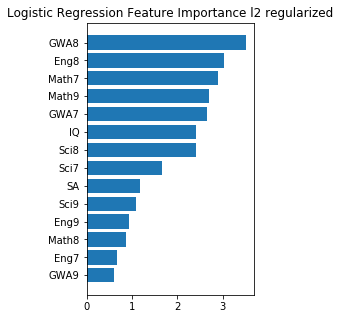

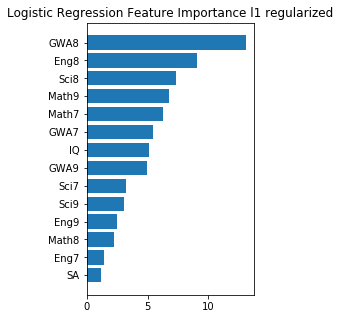

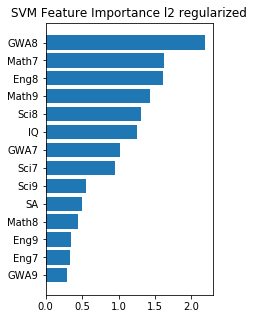

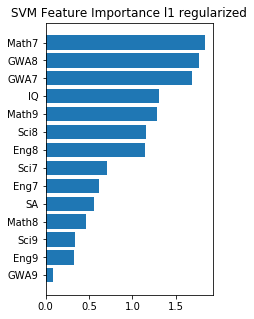

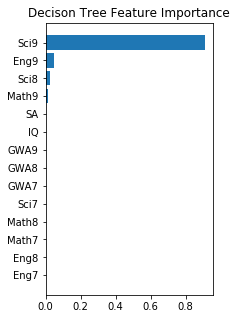

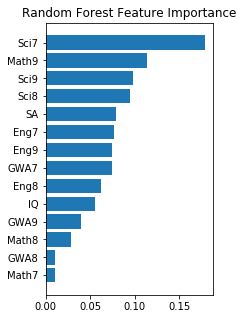

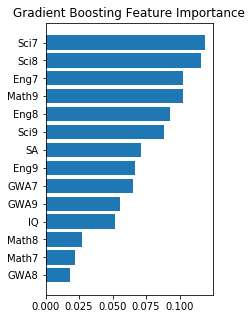

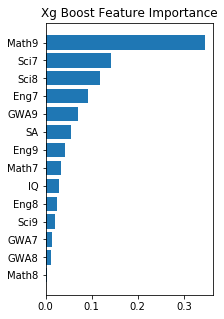

In [9]:
import warnings
warnings.filterwarnings('ignore')
# %%time

feature_names = ['Eng7', 'Eng8', 'Eng9', 'Math7', 'Math8', 'Math9', 'Sci7', 
                 'Sci8', 'Sci9', 'GWA7', 'GWA8', 'GWA9', 'IQ', 'SA']

X = X_clean[feature_names]
y = X_clean['Target']


a = train_knn(X,y,scale=MinMaxScaler())
# print(a)
b = train_logistic(X,y,reg='l2',scale=MinMaxScaler())
# print(b)
c = train_logistic(X,y,reg='l1',scale=MinMaxScaler())
# print(c)
d = train_svm(X,y,reg='l2',scale=MinMaxScaler())
# print(d)
e = train_svm(X,y,reg='l1',scale=MinMaxScaler())
# print(e)
f = train_Nsvm(X,y,reg='rbf',scale=MinMaxScaler())
# print(f)
g = train_Nsvm_poly(X,y,reg='poly',scale=MinMaxScaler())

h = train_DecisonTree(X,y,scale=None,draw_tree=True)

i = train_RandomForest(X,y,scale=None,draw_tree=True)
j = train_GradientBoosting(X,y,scale=None,draw_tree=True)
k = train_XGBoosting(X,y,scale=None,draw_tree=True)
l = train_naive_Bayes(X,y,scale=None)

In [ ]:
# print(classification_report(y_test, gs_cv.best_estimator_.predict(X_test)))

In [11]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable']
df2 = pd.DataFrame(columns=cols)
pd.set_option('display.max_colwidth', -1)
df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g
df2.loc[7] = h
df2.loc[8] = i
df2.loc[9] = j
df2.loc[10] = k
df2.loc[11] = l
df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,kNN,0.828,N_Neighbor = 5,NA
1,Logistic (l2),0.840,C = 1000,GWA8
2,Logistic (l1),0.840,C = 10,GWA8
3,SVM (l2),0.840,C = 3,GWA8
4,SVM (l1),0.856,C = 3,Math7
5,Nonlinear SVM (rbf),0.920,"{'C': 10, 'gamma': 0.2}",NA
6,Nonlinear SVM (poly),0.880,"{'C': 10, 'coef0': 15, 'degree': 2}",NA
7,Decision Tree,0.880,"{'max_depth': 3, 'max_features': 0.2, 'min_samples_leaf': 5}",Sci9
8,Random Forest,0.880,"{'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 100}",Sci7
9,Gradient Boosting,0.880,"{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 3, 'n_estimators': 150}",Sci7


In [7]:
df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,kNN,0.828,N_Neighbor = 5,NA
1,Logistic (l2),0.840,C = 1000,GWA8
2,Logistic (l1),0.840,C = 10,GWA8
3,SVM (l2),0.840,C = 3,GWA8
4,SVM (l1),0.844,C = 5,Math7
5,Nonlinear SVM (rbf),0.920,"{'C': 10, 'gamma': 0.2}",NA
6,Nonlinear SVM (poly),0.880,"{'C': 10, 'coef0': 15, 'degree': 2}",NA
7,Decision Tree,0.880,"{'max_depth': 3, 'max_features': 0.2, 'min_samples_leaf': 5}",Sci9
8,Random Forest,0.880,"{'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 100}",Sci7
9,Gradient Boosting,0.880,"{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 3, 'n_estimators': 150}",Sci7


# 2. For the Entire data , plz note that the Poly SVM takes an extremely large amount of time to run, hence only degree hyper-parameter is varied 

In [8]:
df_UPCAT = pd.read_excel('UPCAT_DATA2.xlsx', sheetname='AllData')
dummy = df_UPCAT
dummy.head()
X_transition = pd.DataFrame(df_UPCAT)
X_clean = DataFrameImputer().fit_transform(X_transition)

X_clean.isnull().sum()
X_clean.shape

(1010, 19)

In [9]:
dummy.head()

,Batch,Eng7,Eng8,Eng9,Math7,Math8,Math9,Sci7,Sci8,Sci9,GWA7,GWA8,GWA9,UP,IQ,SA,C1,C2,Target
0,2005,77,82.0,86,94,87,92.0,84,80,92,1.4764,1.5045,1.4098,1,55.0,28,1,4.0,1
1,2005,57,57.0,59,55,46,57.0,53,45,53,2.6557,2.7000,2.7008,1,38.0,19,5,3.0,0
2,2005,55,52.0,55,57,53,51.0,57,62,51,2.6132,2.6818,2.7172,0,17.0,9,5,6.0,0
3,2005,69,78.0,78,87,79,79.0,83,82,79,1.7217,1.6136,1.7049,1,45.0,28,1,4.0,0
4,2005,64,71.0,68,71,57,54.0,60,59,55,2.4245,2.4318,2.4713,1,67.0,56,1,5.0,0


In [10]:
# print(classification_report(y_test, gs_cv.best_estimator_.predict(X_test)))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# %%time

feature_names = ['Eng7', 'Eng8', 'Eng9', 'Math7', 'Math8', 'Math9', 'Sci7', 
                 'Sci8', 'Sci9', 'GWA7', 'GWA8', 'GWA9', 'IQ', 'SA']

X = X_clean[feature_names]
y = X_clean['Target']


a = train_knn(X,y,scale=MinMaxScaler())
# print(a)
b = train_logistic(X,y,reg='l2',scale=MinMaxScaler())
# print(b)
c = train_logistic(X,y,reg='l1',scale=MinMaxScaler())
# print(c)
d = train_svm(X,y,reg='l2',scale=MinMaxScaler())
# print(d)
e = train_svm(X,y,reg='l1',scale=MinMaxScaler())
# print(e)
f = train_Nsvm(X,y,reg='rbf',scale=MinMaxScaler())
# print(f)
g = train_Nsvm_poly(X,y,reg='poly',scale=MinMaxScaler())

cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g
#df2.loc[6] = g
print(df2)

KNN Classifier



Logistic - l2



Logistic - l1



SVM - l2



SVM - l1



Non-Linear SVM with Kernel - rbf



Non-Linear SVM with Kernel - poly


In [ ]:
df2